In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from robustRandomForest import RobustRandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from tqdm import tqdm

## Импортируем данные

In [3]:
#reader = pd.ExcelFile('tbloodset4.1.xlsx')
#df = reader.parse('data', index_col=0)[['CDH1', 'CD29', 'CCND1', 'Koll_2', 'CD86', 'MiR_181', 'MiR_25']]
df = pd.read_csv('5_can.csv')
display(df.head())
display(df.shape)

,CDH1,CD29,CD86,Koll_2,CCND1,MiR_181,MiR_25
0,92.60,30.00,28.58,26.11,86.69,0.9,0.1
1,88.45,1.61,19.02,27.93,93.91,3.0,1.8
2,93.78,5.23,11.33,16.18,97.31,0.7,0.4
3,83.42,22.79,19.02,32.10,93.91,4.6,4.0
4,99.76,7.59,10.08,15.67,95.54,55.7,66.3


(44, 7)

## Тестируем первую модель

In [4]:
X = df[['CDH1', 'CCND1']]
y = df[['MiR_181']]

In [5]:
delta = 0.0001
n = 500

sk_mae, huber_mae, tukey_mae, lowess_mae = [], [], [], []
sk_mse, huber_mse, tukey_mse, lowess_mse = [], [], [], []

for _ in tqdm(range(n)):

    X_train, X_test, Y_train, Y_test = train_test_split(X, y)

    Y_train = MaxAbsScaler().fit_transform(Y_train.to_numpy().reshape(-1, 1)).flatten()
    Y_train = pd.Series(Y_train)
    Y_test = MaxAbsScaler().fit_transform(Y_test.to_numpy().reshape(-1, 1)).flatten()
    Y_test = pd.Series(Y_test)

    base_rf = RandomForestRegressor(n_jobs=-1)
    base_rf.fit(X_train, Y_train)
    base_rf_pred = base_rf.predict(X_test)
    sk_mae.append(mean_absolute_error(base_rf_pred, Y_test))
    sk_mse.append(mean_squared_error(base_rf_pred, Y_test))

    huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, delta=delta, robustness='huber')
    huber_rrf.fit(X_train, Y_train)
    huber_rrf_pred = huber_rrf.predict(X_test)
    huber_mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
    huber_mse.append(mean_squared_error(huber_rrf_pred, Y_test))

    tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, delta=delta, robustness='tukey')
    tukey_rrf.fit(X_train, Y_train)
    tukey_rrf_pred = tukey_rrf.predict(X_test)
    tukey_mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
    tukey_mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

    lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
    lowess_rrf.fit(X_train, Y_train, alpha=20)
    lowess_rrf_pred = lowess_rrf.predict(X_test)
    lowess_mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
    lowess_mse.append(mean_squared_error(lowess_rrf_pred, Y_test))

  0%|          | 0/500 [00:00<?, ?it/s]

 32%|███▏      | 158/500 [14:58<31:55,  5.60s/it]c:\Users\maiha\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 79%|███████▉  | 394/500 [2:07:04<36:30:58, 1240.17s/it]c:\Users\maiha\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 500/500 [2:13:18<00:00, 16.00s/it]     


In [6]:
print(f'Mean MAE sk: {np.mean(sk_mae):.3f}')
print(f'Mean MAE huber: {np.mean(huber_mae):.3f}')
print(f'Mean MAE tukey: {np.mean(tukey_mae):.3f}')
print(f'Mean MAE lowess: {np.mean(lowess_mae):.3f}\n')

print(f'Mean MSE sk: {np.mean(sk_mse):.3f}')
print(f'Mean MSE huber: {np.mean( huber_mse):.3f}')
print(f'Mean MSE tukey: {np.mean(tukey_mse):.3f}')
print(f'Mean MSE lowess: {np.mean(lowess_mse):.3f}')

Mean MAE sk: 0.251
Mean MAE huber: 0.227
Mean MAE tukey: 0.239
Mean MAE lowess: 0.222

Mean MSE sk: 0.132
Mean MSE huber: 0.125
Mean MSE tukey: 0.124
Mean MSE lowess: 0.132


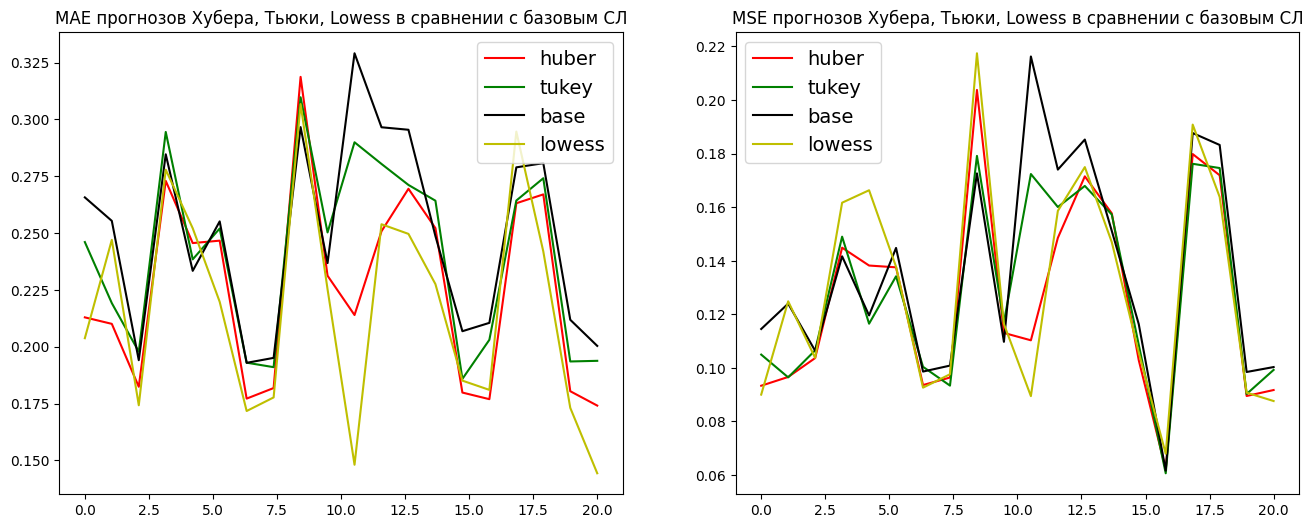

In [7]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title(f'MAE прогнозов Хубера, Тьюки, Lowess в сравнении с базовым СЛ')
plt.plot(np.linspace(0, 20, 20), huber_mae[:20], color='r', label='huber')
plt.plot(np.linspace(0, 20, 20), tukey_mae[:20], color='g', label='tukey')
plt.plot(np.linspace(0, 20, 20), sk_mae[:20], color='black', label='base')
plt.plot(np.linspace(0, 20, 20), lowess_mae[:20], color='y', label='lowess')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.title(f'MSE прогнозов Хубера, Тьюки, Lowess в сравнении с базовым СЛ')
plt.plot(np.linspace(0, 20, 20), huber_mse[:20], color='r', label='huber')
plt.plot(np.linspace(0, 20, 20), tukey_mse[:20], color='g', label='tukey')
plt.plot(np.linspace(0, 20, 20), sk_mse[:20], color='black', label='base')
plt.plot(np.linspace(0, 20, 20), lowess_mse[:20], color='y', label='lowess')
plt.legend(fontsize=14)
plt.savefig('Plots/miR1_range.png')
plt.show()

## Тестируем вторую модель

In [8]:
X = df[['CD29', 'CCND1']]
y = df[['MiR_25']]

In [9]:
delta = 0.0001
n = 500

sk_mae, huber_mae, tukey_mae, lowess_mae = [], [], [], []
sk_mse, huber_mse, tukey_mse, lowess_mse = [], [], [], []

for _ in tqdm(range(n)):

    X_train, X_test, Y_train, Y_test = train_test_split(X, y)

    Y_train = MaxAbsScaler().fit_transform(Y_train.to_numpy().reshape(-1, 1)).flatten()
    Y_train = pd.Series(Y_train)
    Y_test = MaxAbsScaler().fit_transform(Y_test.to_numpy().reshape(-1, 1)).flatten()
    Y_test = pd.Series(Y_test)

    base_rf = RandomForestRegressor(n_jobs=-1)
    base_rf.fit(X_train, Y_train)
    base_rf_pred = base_rf.predict(X_test)
    sk_mae.append(mean_absolute_error(base_rf_pred, Y_test))
    sk_mse.append(mean_squared_error(base_rf_pred, Y_test))

    huber_rrf = RobustRandomForest(n_jobs=-1, regression = True, delta=delta, robustness='huber')
    huber_rrf.fit(X_train, Y_train)
    huber_rrf_pred = huber_rrf.predict(X_test)
    huber_mae.append(mean_absolute_error(huber_rrf_pred, Y_test))
    huber_mse.append(mean_squared_error(huber_rrf_pred, Y_test))

    tukey_rrf = RobustRandomForest(n_jobs=-1, regression = True, delta=delta, robustness='tukey')
    tukey_rrf.fit(X_train, Y_train)
    tukey_rrf_pred = tukey_rrf.predict(X_test)
    tukey_mae.append(mean_absolute_error(tukey_rrf_pred, Y_test))
    tukey_mse.append(mean_squared_error(tukey_rrf_pred, Y_test))

    lowess_rrf = RobustRandomForest(n_jobs=-1, regression=True, robustness='lowess')
    lowess_rrf.fit(X_train, Y_train, alpha=20)
    lowess_rrf_pred = lowess_rrf.predict(X_test)
    lowess_mae.append(mean_absolute_error(lowess_rrf_pred, Y_test))
    lowess_mse.append(mean_squared_error(lowess_rrf_pred, Y_test))

100%|██████████| 500/500 [27:20<00:00,  3.28s/it]


In [10]:
print(f'Mean MAE sk: {np.mean(sk_mae):.3f}')
print(f'Mean MAE huber: {np.mean(huber_mae):.3f}')
print(f'Mean MAE tukey: {np.mean(tukey_mae):.3f}')
print(f'Mean MAE lowess: {np.mean(lowess_mae):.3f}\n')

print(f'Mean MSE sk: {np.mean(sk_mse):.3f}')
print(f'Mean MSE huber: {np.mean( huber_mse):.3f}')
print(f'Mean MSE tukey: {np.mean(tukey_mse):.3f}')
print(f'Mean MSE lowess: {np.mean(lowess_mse):.3f}')

Mean MAE sk: 0.212
Mean MAE huber: 0.184
Mean MAE tukey: 0.202
Mean MAE lowess: 0.178

Mean MSE sk: 0.115
Mean MSE huber: 0.110
Mean MSE tukey: 0.109
Mean MSE lowess: 0.123


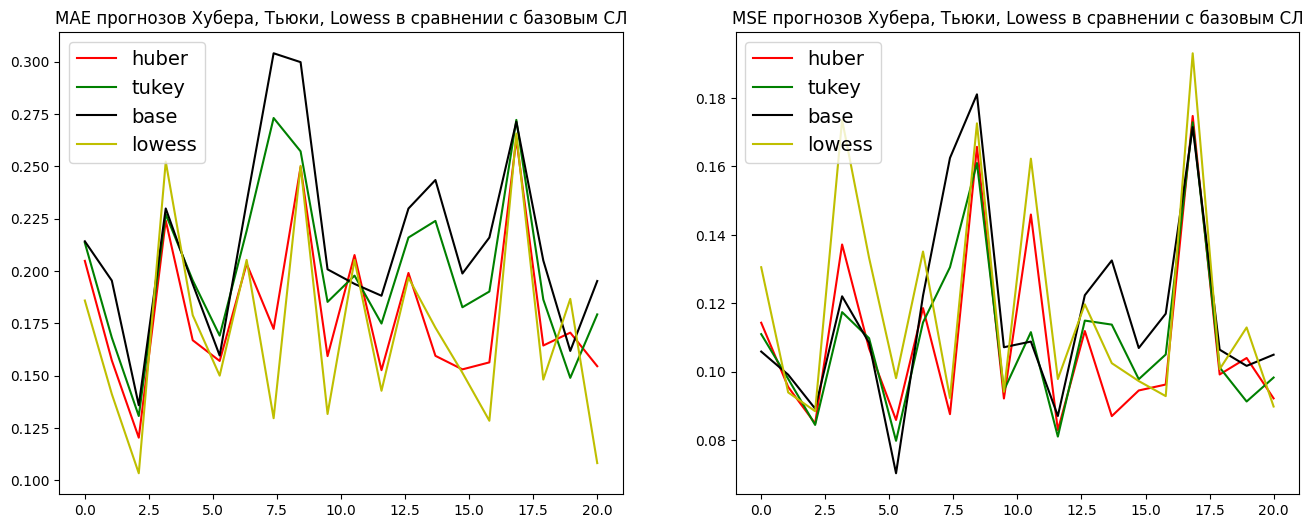

In [11]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title(f'MAE прогнозов Хубера, Тьюки, Lowess в сравнении с базовым СЛ')
plt.plot(np.linspace(0, 20, 20), huber_mae[:20], color='r', label='huber')
plt.plot(np.linspace(0, 20, 20), tukey_mae[:20], color='g', label='tukey')
plt.plot(np.linspace(0, 20, 20), sk_mae[:20], color='black', label='base')
plt.plot(np.linspace(0, 20, 20), lowess_mae[:20], color='y', label='lowess')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
plt.title(f'MSE прогнозов Хубера, Тьюки, Lowess в сравнении с базовым СЛ')
plt.plot(np.linspace(0, 20, 20), huber_mse[:20], color='r', label='huber')
plt.plot(np.linspace(0, 20, 20), tukey_mse[:20], color='g', label='tukey')
plt.plot(np.linspace(0, 20, 20), sk_mse[:20], color='black', label='base')
plt.plot(np.linspace(0, 20, 20), lowess_mse[:20], color='y', label='lowess')
plt.legend(fontsize=14)
plt.savefig('Plots/miR2_range.png')
plt.show()